# Deep Convolutional GANs

Jun Zhu

---

The DCGAN architecture was [first](https://arxiv.org/pdf/1511.06434.pdf) explored in 2016 and has seen impressive results in generating new images.

In this project, we will train a DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![](images/svhn_gan.png)


In [1]:
%matplotlib inline

import os
import os.path as osp
from urllib.request import urlretrieve
from tqdm import tqdm
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, LeakyReLU, Reshape
)
from tensorflow.keras import Model
import tensorflow.keras.datasets as kds

tf.__version__, tf.config.list_physical_devices('GPU')

('2.3.0', [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

## SVHN Data
### Download data

In [2]:
data_dir = 'data/'

try:
    os.mkdir(data_dir)
except OSError:
    pass

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not osp.isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not osp.isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [3]:
def extract_data(data):
    images, labels = data['X'], data['y']
    images = np.moveaxis(images, -1, 0)
    labels = labels.squeeze(axis=-1)
    return images, labels

train_data = loadmat(data_dir + 'train_32x32.mat')
test_data = loadmat(data_dir + 'test_32x32.mat')

train_images, train_labels = extract_data(train_data)
test_images, test_labels = extract_data(test_data)

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((73257, 32, 32, 3), (73257,), (26032, 32, 32, 3), (26032,))

### Visualization

Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

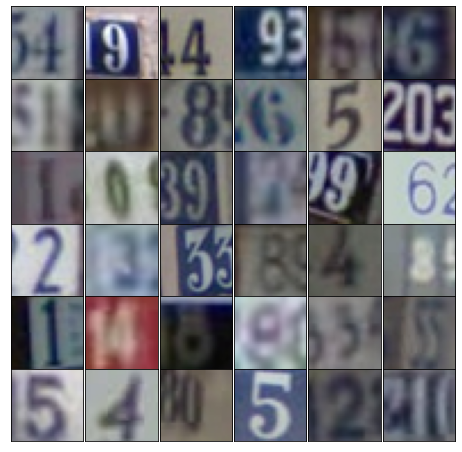

In [4]:
def plot_data(data, indices=None):
    if indices is None:
        indices = np.arange(36)

    fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(8, 8))
    for i, ax in zip(indices, axes.flatten()):
        ax.imshow(data[i], aspect='equal')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)

plot_data(train_images, np.random.choice(np.arange(train_images.shape[0]), 36))

### Data preprocessing

- First, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. 
- We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [5]:
def preprocess(data):
    data = data.astype(np.float32)
    data -= 127.5
    data /= 127.5
    return data

train_images = preprocess(train_images)
test_images = preprocess(test_images)

train_images.min(), train_images.max()

(-1.0, 1.0)

## DCGAN

Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](images/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [6]:
class Generator(Model):
    """Generator model."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.shape_in = (100,)

        self._d1 = Dense(4 * 4 * 512)
        
        self._conv1 = Conv2DTranspose(256, (5, 5), strides=2, padding='same')
        self._bn1 = BatchNormalization()
        
        self._conv2 = Conv2DTranspose(128, (5, 5), strides=2, padding='same')
        self._bn2 = BatchNormalization()
        
        self._conv3 = Conv2DTranspose(3, (5, 5), strides=2, padding='same')
        
    def call(self, inputs, training=None):
        x = tf.nn.relu(tf.reshape(self._d1(inputs), [-1, 4, 4, 512]))
        x = tf.nn.relu(self._bn1(self._conv1(x), training=training))
        x = tf.nn.relu(self._bn2(self._conv2(x), training=training))
        x = tf.nn.tanh(self._conv3(x))
        return x
    
    def summary(self):
        self.build(input_shape=(None, *self.shape_in))
        return super().summary()
    

class Discriminator(Model):
    """Discriminator model.
    
    The discriminator is basically just a convolutional classifier. 
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.shape_in = (32, 32, 3)
        
        self._conv1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same')
        
        self._conv2 = Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self._bn2 = BatchNormalization()
        
        self._conv3 = Conv2D(256, (5, 5), strides=(2, 2), padding='same')
        self._bn3 = BatchNormalization()
        
        self._f1 = Flatten()
        self._d1 = Dense(1)
        
    
    def call(self, inputs, training=None):
        x = tf.nn.leaky_relu(self._conv1(inputs), alpha=0.2)
        x = tf.nn.leaky_relu(self._bn2(self._conv2(x), training=training), alpha=0.2)
        x = tf.nn.leaky_relu(self._bn3(self._conv3(x), training=training), alpha=0.2)
        x = self._d1(self._f1(x))
        return x
    
    def summary(self):
        self.build(input_shape=(None, *self.shape_in))
        return super().summary()
    

generator = Generator(name='generator')
discriminator = Discriminator(name='discriminator')

generator.summary(), discriminator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  827392    
_________________________________________________________________
conv2d_transpose (Conv2DTran multiple                  3277056   
_________________________________________________________________
batch_normalization (BatchNo multiple                  1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr multiple                  819328    
_________________________________________________________________
batch_normalization_1 (Batch multiple                  512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr multiple                  9603      
Total params: 4,934,915
Trainable params: 4,934,147
Non-trainable params: 768
_____________________________________________

(None, None)

In [7]:
class DcGAN:
    """The DcGAN agent."""
    def __init__(self, generator, discriminator):
        self._g_model = generator
        self._d_model = discriminator
        
        # callable
        self._cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
        
    def _compute_d_loss(self, z, real_image):
        fake_image = self._g_model(z, True)
        real_logits = self._d_model(real_image, True)
        fake_logits = self._d_model(fake_image, True)

        # Train the discriminator to maximize the probability of assigning the 
        # correct labels to both faked and real images.
        loss_real = self._cross_entropy(tf.ones_like(real_logits), real_logits)
        loss_fake = self._cross_entropy(tf.zeros_like(fake_logits), fake_logits)
        return loss_real + loss_fake

    def _compute_g_loss(self, z):
        fake_image = self._g_model(z, True)
        fake_logits = self._d_model(fake_image, True)

        # Train the generator to maximize the probability that faked images
        # are predicted as real.
        return self._cross_entropy(tf.ones_like(fake_logits), fake_logits)
        
    def train(self, train_images, *,
              z_size=100,
              epochs=100,
              batch_size=16,
              learning_rate=1e-4,
              generator_update_frequency=2):

        d_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5)
        g_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5)

        # store losses for each epoch
        d_losses, g_losses = [], []
        
        for epoch in range(epochs):

            train_ds = tf.data.Dataset.from_tensor_slices(
                train_images).shuffle(buffer_size=10000).batch(batch_size)

            step = 0
            d_loss_epoch = 0
            g_loss_epoch = 0
            for batch_data in train_ds:

                step += 1
                
                batch_z = tf.random.uniform(
                    shape=[batch_size, self._g_model.shape_in[0]], minval=-1., maxval=1.)

                with tf.GradientTape() as tape:
                    d_loss = self._compute_d_loss(batch_z, batch_data)
                grads = tape.gradient(d_loss, self._d_model.trainable_variables)
                d_optimizer.apply_gradients(zip(grads, self._d_model.trainable_variables))

                d_loss_epoch += float(d_loss)
                
                if step % generator_update_frequency == 0:
                    with tf.GradientTape() as tape:
                        g_loss = self._compute_g_loss(batch_z)
                    grads = tape.gradient(g_loss, self._g_model.trainable_variables)
                    g_optimizer.apply_gradients(zip(grads, self._g_model.trainable_variables))

                    g_loss_epoch += float(g_loss)

            d_loss_epoch /= step
            d_losses.append(d_loss_epoch)

            g_loss_epoch /= step
            g_losses.append(g_loss_epoch)

            print(f"Epoch: {epoch + 1:04d}, "
                  f"loss (discriminator): {d_loss_epoch:.4f}, "
                  f"loss (generator): {g_loss_epoch:.4f}")
                
        return d_losses, g_losses

    def predict(self, inputs):
        return self._g_model(inputs, training=False).numpy()

### Train model

In [8]:
agent = DcGAN(generator, discriminator)
d_losses, g_losses = agent.train(train_images, 
                                 epochs=30, 
                                 batch_size=128, 
                                 learning_rate=2e-4,
                                 generator_update_frequency=4)

Epoch: 0001, loss (discriminator): 0.1312, loss (generator): 2.5204
Epoch: 0002, loss (discriminator): 0.1396, loss (generator): 1.4819
Epoch: 0003, loss (discriminator): 0.1293, loss (generator): 1.2518
Epoch: 0004, loss (discriminator): 0.1750, loss (generator): 1.2039
Epoch: 0005, loss (discriminator): 0.2989, loss (generator): 1.0600
Epoch: 0006, loss (discriminator): 0.2667, loss (generator): 1.0982
Epoch: 0007, loss (discriminator): 0.2880, loss (generator): 1.1741
Epoch: 0008, loss (discriminator): 0.2713, loss (generator): 1.1247
Epoch: 0009, loss (discriminator): 0.3260, loss (generator): 1.0548
Epoch: 0010, loss (discriminator): 0.2992, loss (generator): 1.1375
Epoch: 0011, loss (discriminator): 0.2792, loss (generator): 1.1242
Epoch: 0012, loss (discriminator): 0.2582, loss (generator): 1.1550
Epoch: 0013, loss (discriminator): 0.2997, loss (generator): 1.1143
Epoch: 0014, loss (discriminator): 0.2656, loss (generator): 1.0827
Epoch: 0015, loss (discriminator): 0.2877, loss 

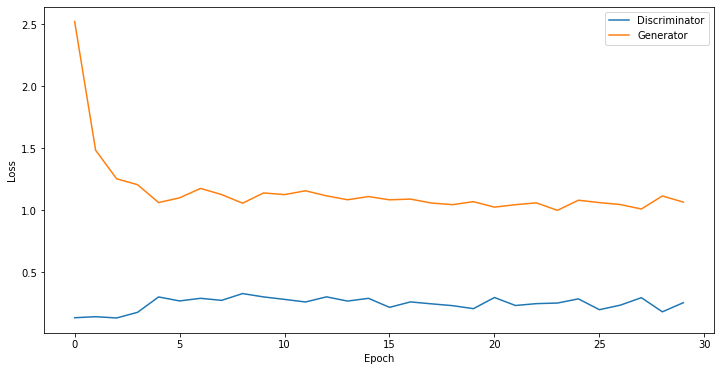

In [9]:
_, ax = plt.subplots(figsize=(12, 6))
ax.plot(d_losses, label='Discriminator')
ax.plot(g_losses, label='Generator')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
_ = ax.legend()

### Prediction

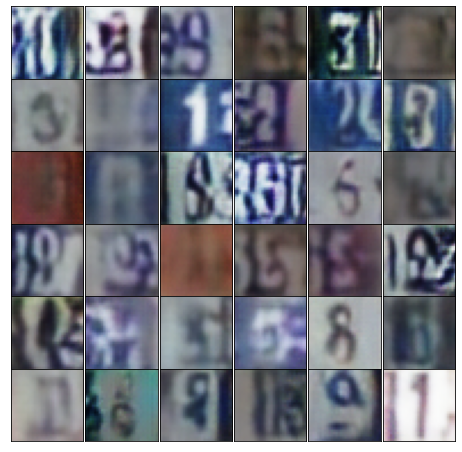

In [10]:
sample_z = np.random.uniform(-1, 1, size=(36, 100)).astype(np.float32)
predicted = agent.predict(sample_z)
predicted = (predicted * 127.5 + 127.5).astype(np.uint8)

plot_data(predicted)